In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import scipy.special
import statsmodels as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

import pymc as pm

from tqdm.auto import tqdm as tqdm_auto
from tqdm.notebook import tqdm

In [ ]:
d1 = pd.read_csv("../data/raw/UTR3_sequence_counts_05_23_23.tsv", sep="\t", index_col=0, header=[0, 1, 2])
d1.index.name = "seq"
d1.columns.names = ["cell_type", "replicate", "bin"]

In [3]:
def fit_bayesian_model(library):
    basic_model = pm.Model()

    with basic_model:
        # Priors for unknown model parameters
        # Mixture weights
        psi = pm.Uniform("psi", lower=0.0, upper=1.0)
        p = pm.Beta("p", alpha=3, beta=1)
        n = pm.Uniform("n", lower=0.0, upper=10.0)

        # Likelihood (sampling distribution) of observations
        likelihood = pm.ZeroInflatedNegativeBinomial('zinb', psi=psi, p=p, n=n, observed=library)

        # draw 1000 posterior samples
        idata = pm.find_MAP()
    return idata

In [ ]:
fit_results = list()
for col_id in tqdm(list(d1)):
    cell_type_id, replicate_id, bin_id = col_id
    result = {"cell_type": cell_type_id,
              "replicate": replicate_id,
              "bin": bin_id}
    lib = d1[col_id].values
    idata = fit_bayesian_model(lib)

    # Knowingly using  only 1 out of 4 sampling chains
    fit_params = {"psi": idata["psi"].item(),
                  "p": idata["p"].item(),
                  "n": idata["n"].item(),
                 }
    result |= fit_params
    fit_results.append(result)

In [5]:
pd.DataFrame(fit_results).to_csv("fit_results_utr3_singledist.csv", index=False)

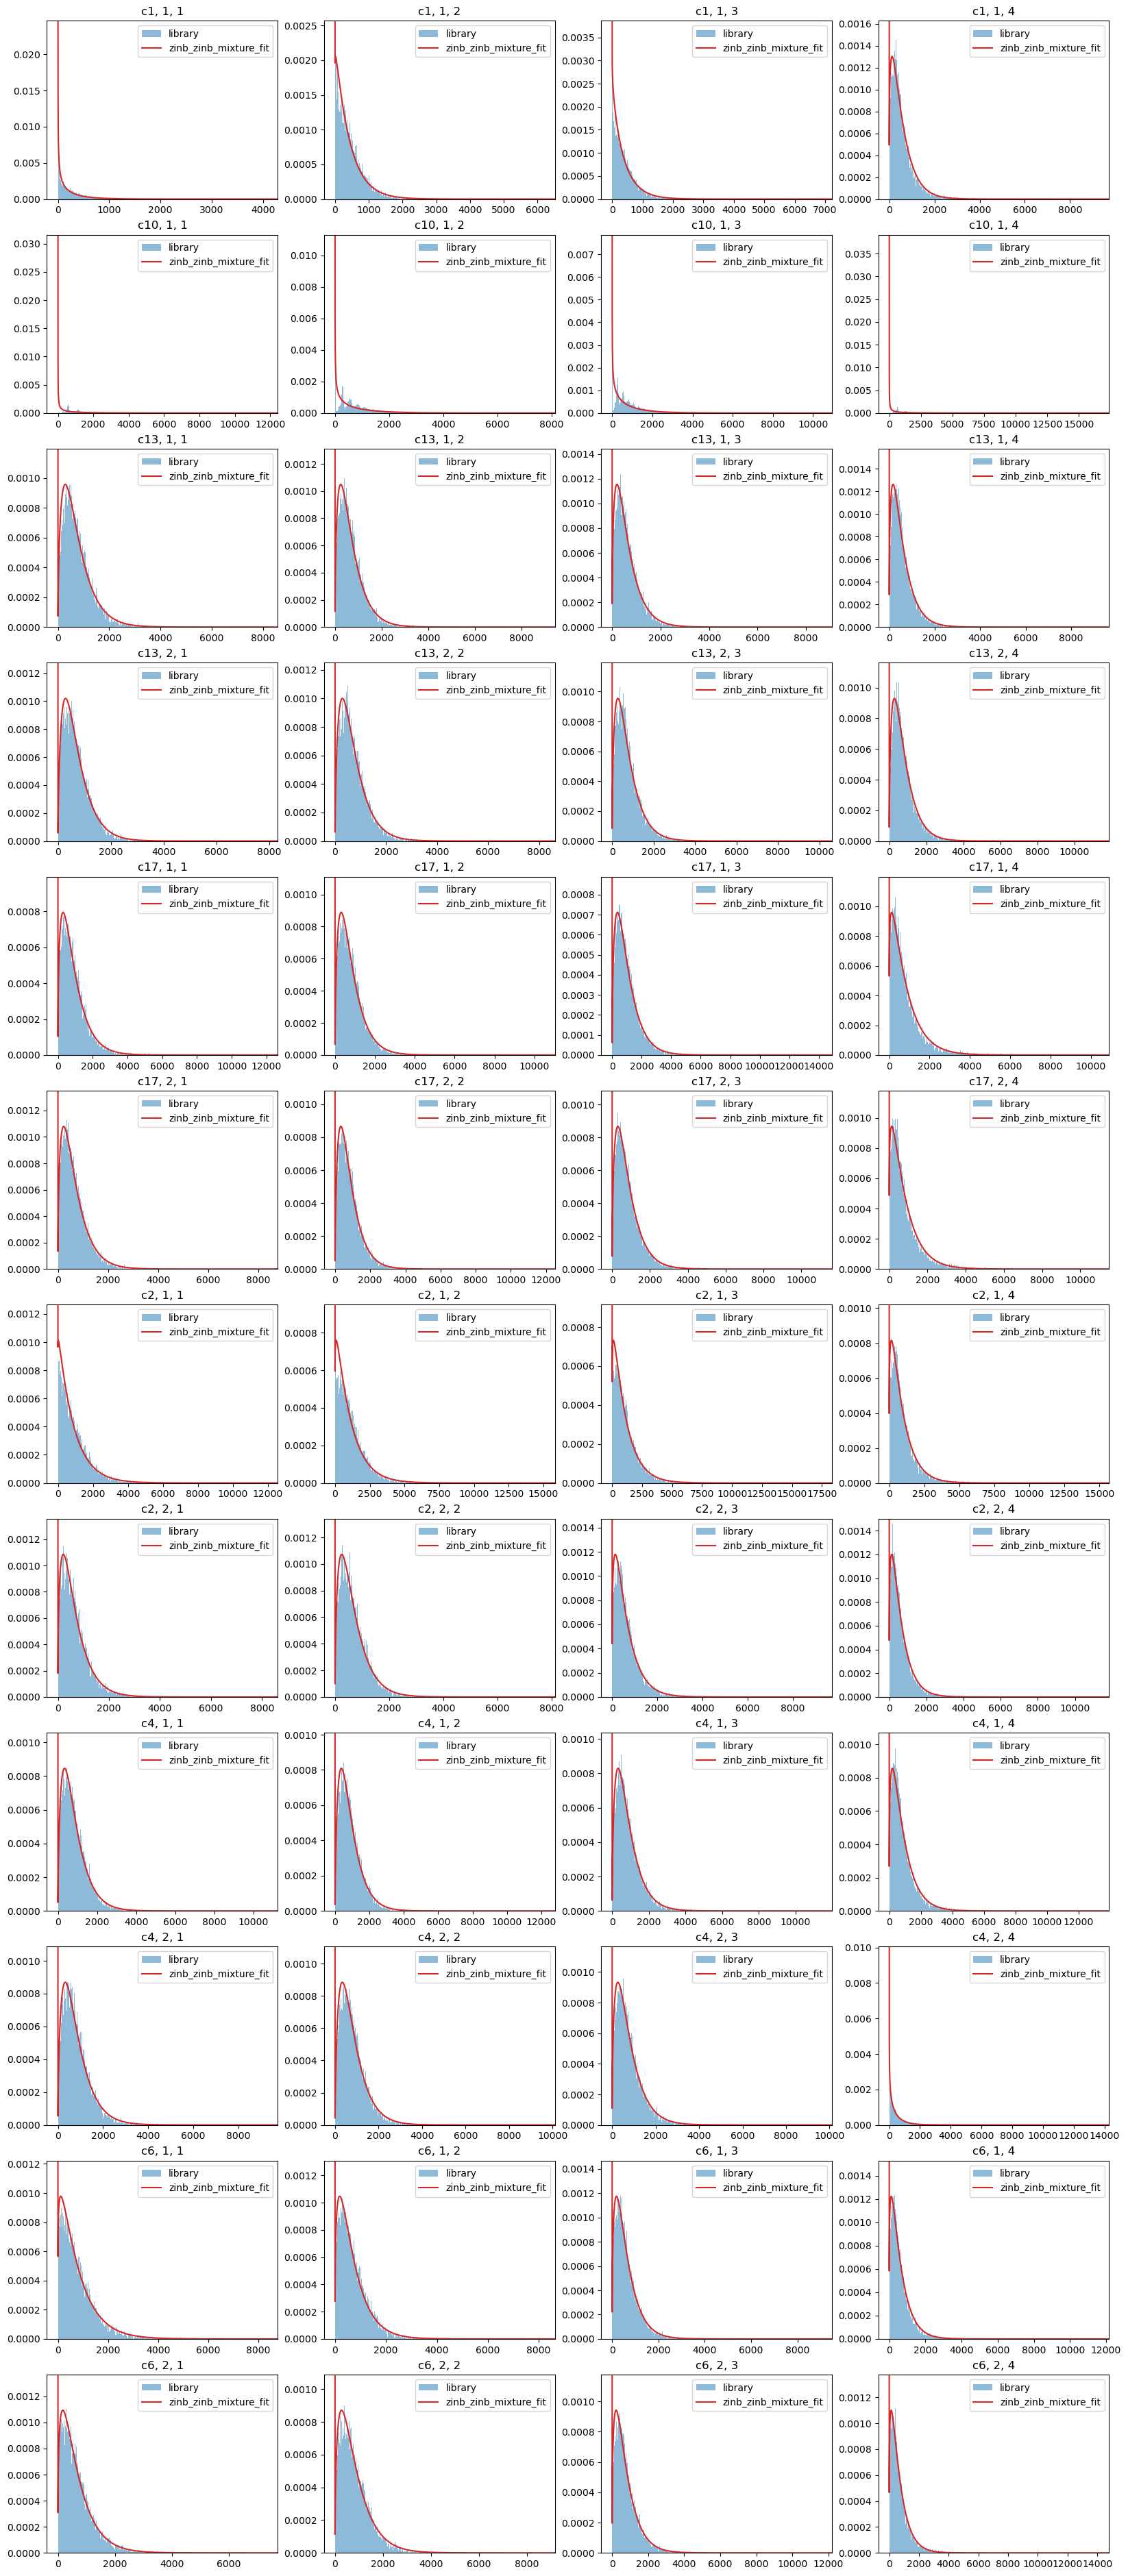

In [6]:
plt.figure(figsize=(20, 48))
for i, (col_id, fit_res) in enumerate(zip(list(d1), fit_results)):
    psi_est = fit_res["psi"]
    p_est = fit_res["p"]
    n_est = fit_res["n"]

    mixture_dist = pm.ZeroInflatedNegativeBinomial.dist(psi=psi_est, p=p_est, n=n_est)

    lib = d1[col_id]
    xlim_empiric = lib.max() 

    logcdf = pm.logcdf(mixture_dist, np.arange(0, xlim_empiric)).eval()
    cdf = np.exp(logcdf)
    pdf = np.concatenate([cdf[:1], cdf[1:] - cdf[:-1]])
    ylim_empiric = pdf[1:].max() * 1.25

    plt.subplot(12, 4, i + 1)
    plt.hist(lib, bins=1000, density=True, alpha=0.5, label="library")
    plt.plot(pdf, color="C3", label="zinb_zinb_mixture_fit")
    plt.legend(loc="upper right")
    plt.xlim(-xlim_empiric // 20, xlim_empiric)
    plt.ylim(0, ylim_empiric)
    plt.title(", ".join(col_id))
plt.savefig("fit_chart_utr3_singledist.svg")
plt.show()